https://stackoverflow.com/questions/45545110/how-do-you-parallelize-apply-on-pandas-dataframes-making-use-of-all-cores-on-o/45545111

In [1]:
!pip install dask distributed --upgrade

Requirement already up-to-date: dask in /opt/conda/lib/python3.6/site-packages (0.20.0)
Requirement already up-to-date: distributed in /opt/conda/lib/python3.6/site-packages (1.24.0)


In [2]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:38675 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.10 GB


In [3]:
import time
import pickle
import matplotlib.pyplot as plt
import pandas
print('pandas',pandas.__version__)
import numpy
print('numpy',numpy.__version__)
import dask.dataframe as dd
from dask.multiprocessing import get

pandas 0.23.4
numpy 1.13.3


In [4]:
df = pandas.DataFrame(
    numpy.random.randint(0,1000,size=(1000, 4)), 
    columns=list('ABCD')
    )
print(df.shape)
df.head()

(1000, 4)


,A,B,C,D
0,317,115,734,654
1,61,760,228,565
2,326,553,638,129
3,879,523,425,953
4,342,421,346,743


In [5]:
ddata = dd.from_pandas(df, npartitions=4)

In [6]:
def double_col_a(row):
    row_as_dict=dict(row)
    return row_as_dict['A']*2

In [7]:
# options for scheduler are 'single-threaded','threads','processes'
start_time = time.time()
res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
print(time.time() - start_time)

0.2194075584411621


In [8]:
with open('multiprocessing_data.pkl','rb') as f: 
    serial_reslts, pool_reslts, lambda_reslts = pickle.load(f)

In [9]:
serial_reslts

{100: 0.018373274803161622,
 1000: 0.1399479866027832,
 10000: 1.534554696083069,
 100000: 16.199815654754637}

In [10]:
pool_reslts

{100: 0.14044344425201416,
 1000: 0.26446497440338135,
 10000: 1.0891453266143798,
 100000: 10.257472801208497}

In [11]:
number_of_tests=10
list_of_row_size=list(pool_reslts.keys())

In [12]:
dask_threads_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='threads')
        test_reslts.append(time.time() - start_time)
    dask_threads_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 0.399857759475708 for 100
elapsed time: 2.2271969318389893 for 1000
elapsed time: 18.34245991706848 for 10000
elapsed time: 193.27287936210632 for 100000


In [13]:
dask_processes_reslts={}
scaling_start=time.time()
for row_count in list_of_row_size:
    test_reslts=[]
    for test_indx in range(number_of_tests):
        df = pandas.DataFrame(numpy.random.randint(0,1000,size=(row_count, 4)), columns=list('ABCD'))
        start_time = time.time()
        ddata = dd.from_pandas(df, npartitions=4)
        res = ddata.map_partitions(lambda df: df.apply((lambda row: double_col_a(row)), axis=1)).compute(scheduler='processes')
        test_reslts.append(time.time() - start_time)
    dask_processes_reslts[row_count]=sum(test_reslts)/number_of_tests
    print('elapsed time:',time.time() - scaling_start,'for',row_count)

elapsed time: 1.5330240726470947 for 100
elapsed time: 3.8963277339935303 for 1000
elapsed time: 13.83120608329773 for 10000
elapsed time: 114.06059956550598 for 100000


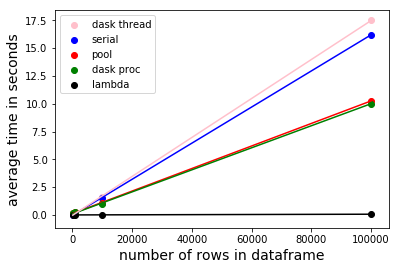

In [23]:
serial_x = list(serial_reslts.keys()) # list_of_row_size
serial_y = list(serial_reslts.values())

pool_x = list(pool_reslts.keys()) # list_of_row_size
pool_y = list(pool_reslts.values())

lambda_x = list(lambda_reslts.keys()) # list_of_row_size
lambda_y = list(lambda_reslts.values())

dask_processes_x = list(dask_processes_reslts.keys()) # list_of_row_size
dask_processes_y = list(dask_processes_reslts.values())

dask_threads_x = list(dask_threads_reslts.keys()) # list_of_row_size
dask_threads_y = list(dask_threads_reslts.values())


_=plt.scatter(dask_threads_x,dask_threads_y,color='pink',label='dask thread')
_=plt.scatter(serial_x,serial_y,color='blue',label='serial')
_=plt.scatter(pool_x,pool_y,color='red',label='pool')
_=plt.scatter(dask_processes_x,dask_processes_y,color='green',label='dask proc')
_=plt.scatter(lambda_x,lambda_y,color='black',label='lambda')
_=plt.ylabel('average time in seconds',fontsize=14)
_=plt.xlabel('number of rows in dataframe',fontsize=14)
_=plt.plot(numpy.unique(serial_x), numpy.poly1d(numpy.polyfit(serial_x, serial_y, 1))(numpy.unique(serial_x)),color='blue') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(pool_x), numpy.poly1d(numpy.polyfit(pool_x, pool_y, 1))(numpy.unique(pool_x)),color='red') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(lambda_x), numpy.poly1d(numpy.polyfit(lambda_x, lambda_y, 1))(numpy.unique(lambda_x)),color='black') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_processes_x), numpy.poly1d(numpy.polyfit(dask_processes_x, dask_processes_y, 1))(numpy.unique(dask_processes_x)),color='green') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
_=plt.plot(numpy.unique(dask_threads_x), numpy.poly1d(numpy.polyfit(dask_threads_x, dask_threads_y, 1))(numpy.unique(dask_threads_x)),color='pink') # https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python

ax = plt.gca()
_=ax.legend()
#ax.grid(True)

Dask vs multiprocessing:
https://github.com/dask/dask/issues/1783

There are additional libraries built on top of Dask,<BR>

https://github.com/jmcarpenter2/swifter
https://github.com/jmcarpenter2/swifter/blob/master/examples/swifter_apply_examples.ipynb
https://github.com/jmcarpenter2/swifter/blob/master/examples/swiftapply_speedcomparison.ipynb